In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from cnn import CNN

import pygad
import time

### Preprocess

In [2]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [3]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [4]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Select event

In [5]:
start_idx = 17400
end_idx = 17650
duration = end_idx - start_idx

In [6]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(250, 96)

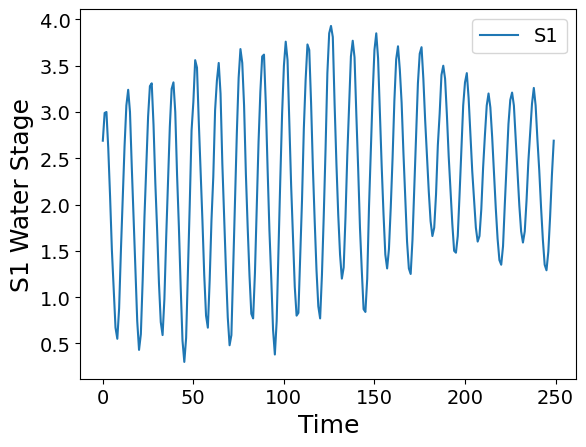

In [7]:
plt.plot(ws1[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [8]:
X = test_X_mask[start_idx:end_idx, :, :]
X_1d = np.reshape(X, -1)

print(X.shape)
print(X_1d.shape)

(250, 96, 16)
(384000,)


In [9]:
gate_state = test_X_mask[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(250, 96, 7)
(168000,)


In [10]:
not_gate1 = test_X_mask[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(250, 96, 2)


In [11]:
not_gate2 = test_X_mask[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(250, 96, 7)


### GA

In [12]:
saved_model = load_model('cnn.h5', compile=False)

In [13]:
def fitness_func(ga_instance, solution, solution_idx):
    # reshape gate to 3d
    solution = np.reshape(solution, (duration, 96, 7))
    
    # get input numpy
    input_np = np.zeros(((duration, 96, 16)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    yhat = saved_model.predict(input_np, verbose=0)
    
    y_max = 0.62
    y_min = 0.2
    
    penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty = np.abs(y_min - yhat[i, j])
                
            else:
                penalty = 0
            
            penalty_sum += penalty
    
    
    if penalty_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_sum
    return fitness

In [14]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [15]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [16]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

CPU time: 2319.4295743 seconds


In [17]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [0.21445888 0.57776411 0.98327059 ... 0.09443458 0.68137772 0.83633345]
Fitness value of the best solution = 0.00011845927278303718


### Post-processing

In [18]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 16)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict(best_input)
best_perf = ws_scaler.inverse_transform(best_perf)

8/8 [==============================] - 0s 1ms/step


In [19]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

553


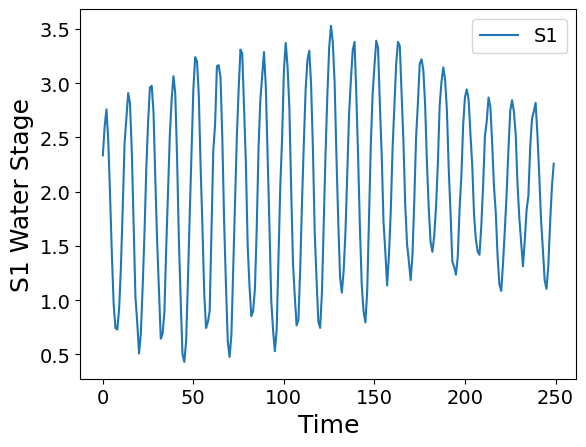

In [20]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [21]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA results/best_gate_event5.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.214459,0.577764,0.983271,0.640308,0.943596,0.445047,0.757256,0.040674,0.736668,0.890341,...,0.041195,0.093599,0.677170,0.531204,0.496975,0.771060,0.451442,0.909434,0.155470,0.244247
1,0.338961,0.239568,0.626799,0.817883,0.652869,0.845554,0.531586,0.007909,0.774710,0.127570,...,0.259682,0.971954,0.885899,0.699431,0.598254,0.210516,0.624501,0.929618,0.371373,0.837134
2,0.256279,0.098678,0.727323,0.763268,0.035947,0.567282,0.331521,0.601591,0.893000,0.375997,...,0.579905,0.077110,0.183195,0.744555,0.105127,0.014786,0.398064,0.423090,0.807227,0.923956
3,0.648254,0.555623,0.997669,0.398643,0.721719,0.146284,0.627323,0.665453,0.115292,0.066541,...,0.252247,0.038779,0.719830,0.416823,0.185449,0.665133,0.865663,0.972713,0.049767,0.955715
4,0.866185,0.651513,0.006296,0.223473,0.930430,0.000167,0.627302,0.940182,0.360347,0.948434,...,0.703648,0.563870,0.555751,0.322402,0.459560,0.978508,0.618663,0.403099,0.646960,0.866019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.269113,0.414788,0.153868,0.375520,0.905417,0.488742,0.508239,0.528224,0.474238,0.717824,...,0.761987,0.474036,0.438361,0.431306,0.550790,0.530159,0.927214,0.025519,0.271237,0.365494
246,0.513544,0.686545,0.784105,0.488756,0.771864,0.944265,0.884236,0.270624,0.259542,0.166336,...,0.700934,0.083723,0.683194,0.533173,0.224635,0.170663,0.167992,0.510430,0.447308,0.466673
247,0.580063,0.708107,0.100752,0.074529,0.928815,0.392716,0.144305,0.359168,0.348315,0.176785,...,0.795781,0.272563,0.971909,0.350952,0.310477,0.688084,0.440489,0.467983,0.242473,0.225561
248,0.663893,0.364651,0.506041,0.339520,0.581684,0.201559,0.258417,0.264984,0.350351,0.409554,...,0.788571,0.918118,0.610322,0.153360,0.426553,0.782706,0.904127,0.553699,0.027440,0.428355


In [22]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA results/best_performance_event5.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,2.334489,2.385965,2.428040,2.450460,2.730762,2.727433,2.792170,2.835021,2.762965,2.811508,...,0.962899,1.044257,1.100050,1.191619,1.285000,1.434316,1.597159,1.647618,1.728682,1.872432
1,2.598936,2.624086,2.730857,2.753052,2.755401,2.804452,2.886566,2.922455,2.474820,2.589171,...,1.316812,1.416547,1.628684,1.726738,1.782245,1.974676,2.134748,2.191318,2.274026,2.451864
2,2.758777,2.903479,2.879540,3.024010,2.560086,2.747932,2.721331,2.855570,2.059226,2.325827,...,1.689229,1.803154,2.174194,2.285081,2.286949,2.468910,2.556893,2.650883,2.690172,2.885757
3,2.471389,2.505346,2.557633,2.722562,2.057749,2.160464,2.163168,2.325164,1.590924,1.816257,...,2.130372,2.280575,2.451515,2.493773,2.508188,2.680700,2.631567,2.725126,2.701241,2.895979
4,1.966125,1.999243,2.141769,2.240080,1.578210,1.765212,1.834357,1.873036,1.092327,1.411349,...,2.756356,3.019943,3.073422,3.086800,3.076410,3.361789,3.010071,3.088004,3.068527,3.333737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1.104125,1.216652,1.347753,1.363821,1.242568,1.348222,1.433160,1.474880,1.485124,1.634715,...,2.291124,2.587134,1.859946,1.957718,2.009183,2.227132,1.488570,1.635833,1.701945,1.809036
246,1.316803,1.477867,1.507808,1.588463,1.733893,1.840701,1.833231,1.987557,2.074795,2.201271,...,2.061602,2.309994,1.573177,1.902079,1.818199,1.980146,1.299330,1.626940,1.563060,1.655274
247,1.709154,1.796060,1.884959,1.936801,2.204247,2.338905,2.338139,2.477662,2.515366,2.674334,...,1.810058,1.993726,1.295921,1.457445,1.562533,1.714750,1.129592,1.265204,1.382924,1.455261
248,2.046572,2.173064,2.098089,2.387191,2.544646,2.625540,2.540021,2.892292,2.795799,2.905172,...,1.421151,1.552371,1.069277,1.189130,1.258994,1.420666,1.126654,1.214880,1.257999,1.466275
